In [1]:
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve, average_precision_score,
    accuracy_score
)
from sklearn.preprocessing import label_binarize

import os, random
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import (
    convnext_tiny, ConvNeXt_Tiny_Weights,
    efficientnet_b0, EfficientNet_B0_Weights
)
import timm
import time
from thop import profile, clever_format

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [2]:
# Paths
data_dir = r"C:/Users/ZA SEYAM/AgroSpectraNet/data/processed"

# Paths
train_dir = os.path.join(data_dir, "train")
val_dir   = os.path.join(data_dir, "validation")
test_dir  = os.path.join(data_dir, "test")

# Transforms (example, can be tuned)
transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_eval = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Datasets
train_ds = ImageFolder(train_dir, transform=transform_train)
val_ds   = ImageFolder(val_dir, transform=transform_eval)
test_ds  = ImageFolder(test_dir, transform=transform_eval)

# Classes
NUM_CLASSES = len(train_ds.classes)
print("Classes:", NUM_CLASSES, train_ds.classes[:5], "...")  # show sample

# Loaders
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=16, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

Classes: 30 ['corn_cercospora_leaf_spot', 'corn_common_rust', 'corn_healthy', 'corn_northern_leaf_blight', 'jute_cescospora_leaf_spot'] ...


In [3]:
class AgroSpectraNetV2(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # ConvNeXt-V2 Tiny
        self.convnext = timm.create_model('convnextv2_tiny', pretrained=True, features_only=True)
        conv_dim = self.convnext.feature_info.channels()[-1]  # get last embedding size

        # EfficientNet-B0 (same as before)
        self.effnet = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.effnet.classifier = nn.Identity()
        eff_dim = 1280

        # Global Avg Pool for both branches
        self.pool = nn.AdaptiveAvgPool2d((1,1))

        # Fusion + Classifier
        self.fc = nn.Sequential(
            nn.Linear(conv_dim + eff_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x1 = self.convnext(x)[-1]        # take last feature map
        x1 = self.pool(x1).flatten(1)

        x2 = self.effnet.features(x)
        x2 = self.pool(x2).flatten(1)

        x = torch.cat([x1, x2], dim=1)
        return self.fc(x)

# Init
model = AgroSpectraNetV2(NUM_CLASSES).to(device)
print(model)

AgroSpectraNetV2(
  (convnext): FeatureListNet(
    (stem_0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (stem_1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    (stages_0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (mlp): GlobalResponseNormMlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (grn): GlobalResponseNorm()
            (fc2): Linear(in_features=384, out_features=96, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1,

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3)
scaler = GradScaler()   # ✅ AMP scaler

# --- Training function ---
def train_one_epoch(model, loader, optimizer, criterion, scaler, device):
    model.train()
    running_loss, correct, total = 0, 0, 0
    pbar = tqdm(loader, desc="Training", leave=False)

    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)

        # ✅ autocast for mixed precision
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix(loss=loss.item(), acc=correct/total)

    return running_loss / total, correct / total

# --- Evaluation function ---
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total

C:\Users\ZA SEYAM\AppData\Local\Temp\ipykernel_8968\1839667932.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()   # ✅ AMP scaler


In [5]:
EPOCHS = 30 
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
best_val_acc = 0.0

for epoch in range(1, EPOCHS+1):
    print(f"\n===== Epoch {epoch}/{EPOCHS} =====")
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, scaler, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    scheduler.step(val_loss)

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Train Loss: {tr_loss:.4f} | Train Acc: {tr_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "C:/Users/ZA SEYAM/AgroSpectraNet/models/trained/AgroSpectraNet_V2.pt")
        print("💾 Saved Best Model")


===== Epoch 1/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

C:\Users\ZA SEYAM\AppData\Local\Temp\ipykernel_5232\1839667932.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ZA SEYAM\AppData\Local\Temp\ipykernel_5232\1839667932.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.6340 | Train Acc: 0.7921
Val   Loss: 0.3272 | Val   Acc: 0.8974
💾 Saved Best Model

===== Epoch 2/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.2986 | Train Acc: 0.8987
Val   Loss: 0.1903 | Val   Acc: 0.9360
💾 Saved Best Model

===== Epoch 3/30 =====


Training:   0%|          | 0/807 [00:16<?, ?it/s]

Train Loss: 0.2451 | Train Acc: 0.9172
Val   Loss: 0.1930 | Val   Acc: 0.9342

===== Epoch 4/30 =====


Training:   0%|          | 0/807 [00:17<?, ?it/s]

Train Loss: 0.2144 | Train Acc: 0.9285
Val   Loss: 0.2141 | Val   Acc: 0.9346

===== Epoch 5/30 =====


Training:   0%|          | 0/807 [00:16<?, ?it/s]

Train Loss: 0.1927 | Train Acc: 0.9364
Val   Loss: 0.2226 | Val   Acc: 0.9389
💾 Saved Best Model

===== Epoch 6/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.1893 | Train Acc: 0.9374
Val   Loss: 0.1586 | Val   Acc: 0.9487
💾 Saved Best Model

===== Epoch 7/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.1634 | Train Acc: 0.9458
Val   Loss: 0.1907 | Val   Acc: 0.9472

===== Epoch 8/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.1512 | Train Acc: 0.9499
Val   Loss: 0.3118 | Val   Acc: 0.9237

===== Epoch 9/30 =====


Training:   0%|          | 0/807 [00:14<?, ?it/s]

Train Loss: 0.1425 | Train Acc: 0.9544
Val   Loss: 0.2035 | Val   Acc: 0.9425

===== Epoch 10/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.1262 | Train Acc: 0.9591
Val   Loss: 0.2650 | Val   Acc: 0.9263

===== Epoch 11/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.0661 | Train Acc: 0.9776
Val   Loss: 0.1695 | Val   Acc: 0.9563
💾 Saved Best Model

===== Epoch 12/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.0443 | Train Acc: 0.9854
Val   Loss: 0.1708 | Val   Acc: 0.9606
💾 Saved Best Model

===== Epoch 13/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.0446 | Train Acc: 0.9845
Val   Loss: 0.1604 | Val   Acc: 0.9602

===== Epoch 14/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.0502 | Train Acc: 0.9839
Val   Loss: 0.1786 | Val   Acc: 0.9566

===== Epoch 15/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.0219 | Train Acc: 0.9917
Val   Loss: 0.1809 | Val   Acc: 0.9621
💾 Saved Best Model

===== Epoch 16/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.0176 | Train Acc: 0.9943
Val   Loss: 0.1735 | Val   Acc: 0.9657
💾 Saved Best Model

===== Epoch 17/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.0146 | Train Acc: 0.9954
Val   Loss: 0.2136 | Val   Acc: 0.9639

===== Epoch 18/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.0183 | Train Acc: 0.9929
Val   Loss: 0.2106 | Val   Acc: 0.9635

===== Epoch 19/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.0085 | Train Acc: 0.9978
Val   Loss: 0.2121 | Val   Acc: 0.9646

===== Epoch 20/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.0082 | Train Acc: 0.9974
Val   Loss: 0.1974 | Val   Acc: 0.9664
💾 Saved Best Model

===== Epoch 21/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.0078 | Train Acc: 0.9973
Val   Loss: 0.1911 | Val   Acc: 0.9642

===== Epoch 22/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.0055 | Train Acc: 0.9980
Val   Loss: 0.2289 | Val   Acc: 0.9628

===== Epoch 23/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.0060 | Train Acc: 0.9977
Val   Loss: 0.1943 | Val   Acc: 0.9696
💾 Saved Best Model

===== Epoch 24/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.0033 | Train Acc: 0.9990
Val   Loss: 0.2011 | Val   Acc: 0.9686

===== Epoch 25/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.0037 | Train Acc: 0.9988
Val   Loss: 0.2125 | Val   Acc: 0.9689

===== Epoch 26/30 =====


Training:   0%|          | 0/807 [00:14<?, ?it/s]

Train Loss: 0.0021 | Train Acc: 0.9995
Val   Loss: 0.2140 | Val   Acc: 0.9668

===== Epoch 27/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.0028 | Train Acc: 0.9991
Val   Loss: 0.2076 | Val   Acc: 0.9689

===== Epoch 28/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.0020 | Train Acc: 0.9993
Val   Loss: 0.2125 | Val   Acc: 0.9678

===== Epoch 29/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.0018 | Train Acc: 0.9995
Val   Loss: 0.2284 | Val   Acc: 0.9678

===== Epoch 30/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.0038 | Train Acc: 0.9985
Val   Loss: 0.2227 | Val   Acc: 0.9657


In [7]:
# Plot Training & Validation Curves (Accuracy in %)
def plot_curves(history, save_path="training_curves.png"):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # (a) Accuracy subplot (converted to percentage)
    axes[0].plot([acc * 100 for acc in history["train_acc"]], label="Train Acc")
    axes[0].plot([acc * 100 for acc in history["val_acc"]], label="Val Acc")
    axes[0].set_title("(a) Training and Validation Accuracy", fontsize=12)
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Accuracy (%)")
    axes[0].legend()
    axes[0].grid(True)

    # (b) Loss subplot (keeps original scale)
    axes[1].plot(history["train_loss"], label="Train Loss")
    axes[1].plot(history["val_loss"], label="Val Loss")
    axes[1].set_title("(b) Training and Validation Loss", fontsize=12)
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Loss")
    axes[1].legend()
    axes[1].grid(True)

    # Adjust layout
    plt.tight_layout()

    # Save figure
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    print(f"✅ Training curves saved at: {save_path}")

    # Show figure
    plt.show()


# Example usage
plot_curves(history, save_path="C:/Users/ZA SEYAM/AgroSpectraNet/results/AgroSpectraV2_training_curves.png")

NameError: name 'history' is not defined

In [9]:
# Load best model
model.load_state_dict(torch.load("C:/Users/ZA SEYAM/AgroSpectraNet/models/trained/AgroSpectraNet_V2.pt"))

# Final evaluation
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"\nFinal Test Loss: {test_loss:.4f} | Final Test Acc: {test_acc:.4f}")

C:\Users\ZA SEYAM\AppData\Local\Temp\ipykernel_20316\1839667932.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Final Test Loss: 0.2544 | Final Test Acc: 0.9565


              precision    recall  f1-score   support

           0       0.94      0.94      0.94        77
           1       1.00      0.99      0.99       179
           2       1.00      1.00      1.00       175
           3       0.97      0.97      0.97       148
           4       0.95      0.77      0.85        47
           5       0.81      0.91      0.86        53
           6       0.93      0.95      0.94        40
           7       0.94      0.99      0.97        86
           8       0.83      0.81      0.82       113
           9       0.83      0.94      0.88        31
          10       0.70      0.64      0.67        11
          11       0.78      0.75      0.77        92
          12       0.85      0.83      0.84        53
          13       0.87      0.88      0.87        66
          14       0.97      1.00      0.99        66
          15       0.97      0.97      0.97        66
          16       0.99      1.00      0.99        66
          17       0.95    

C:\Users\ZA SEYAM\AppData\Local\Temp\ipykernel_22508\769592588.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


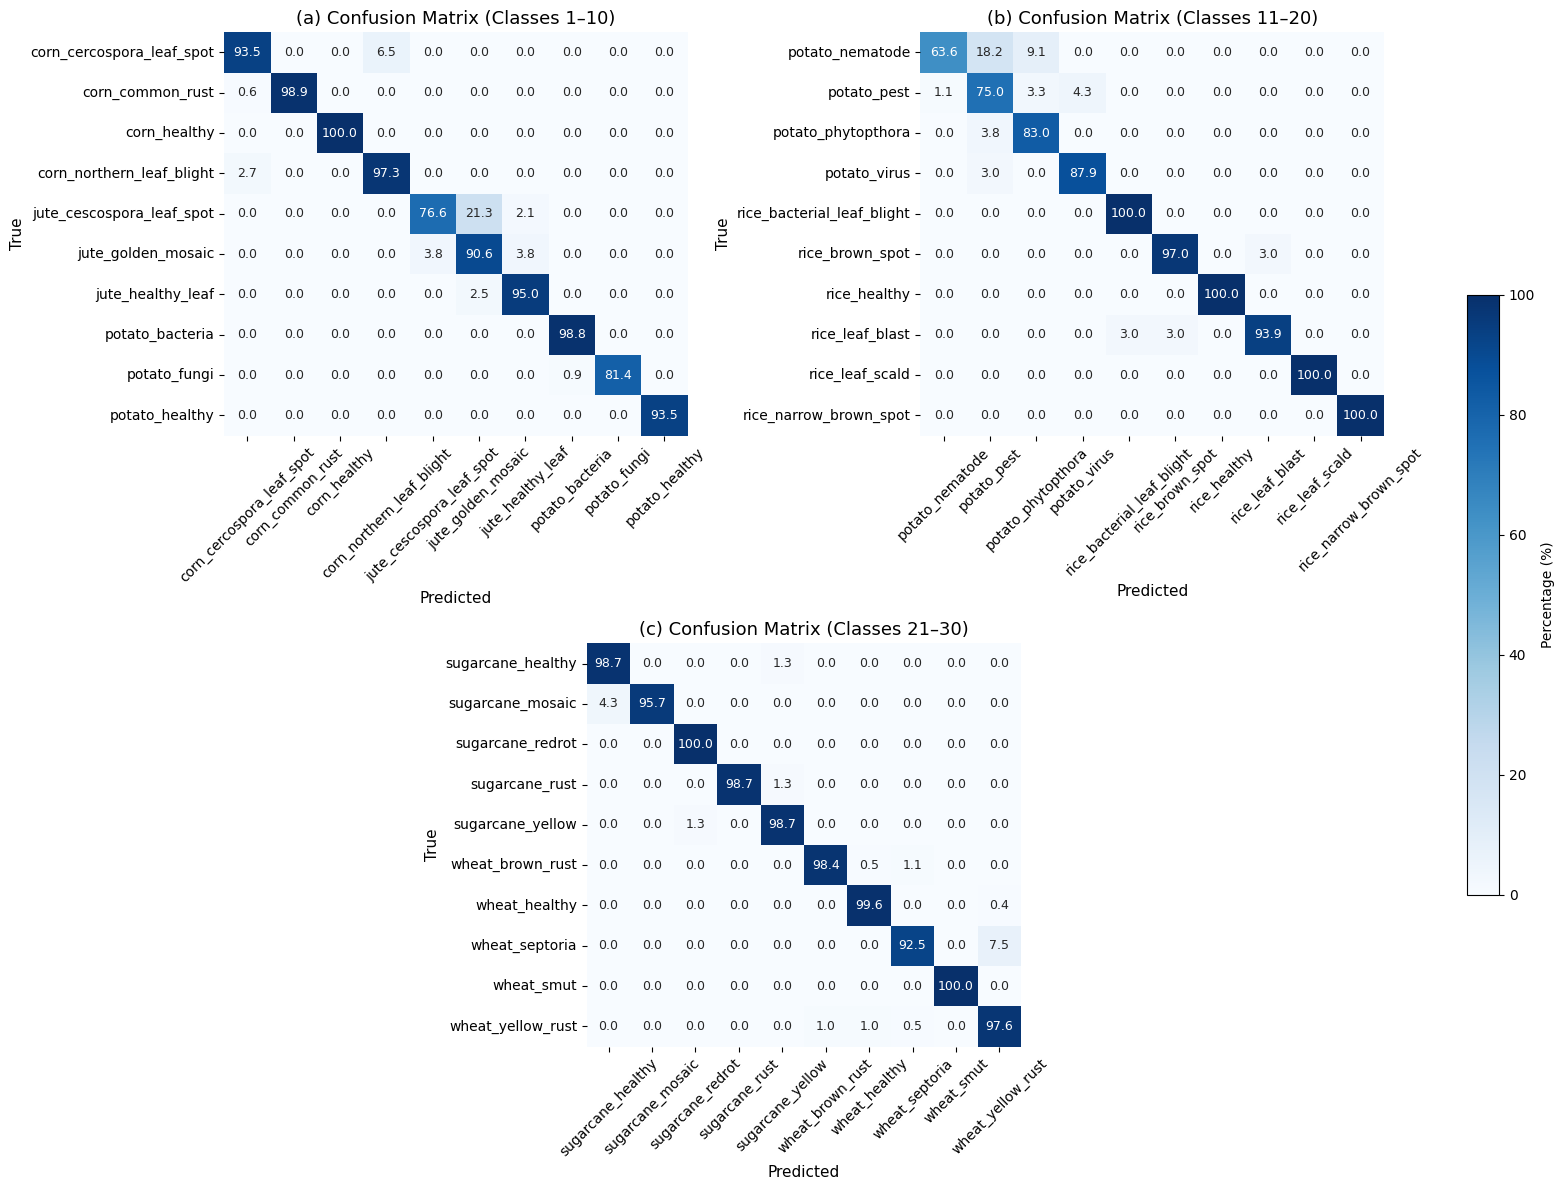

✅ Confusion matrix (percentage) saved successfully at:
C:/Users/ZA SEYAM/AgroSpectraNet/outputs\confusion_matrix_percentage.png
✅ Classification report saved successfully at:
C:/Users/ZA SEYAM/AgroSpectraNet/outputs\classification_report.csv


,precision,recall,f1-score,support
0,0.935065,0.935065,0.935065,77.0
1,1.000000,0.988827,0.994382,179.0
2,1.000000,1.000000,1.000000,175.0
3,0.966443,0.972973,0.969697,148.0
4,0.947368,0.765957,0.847059,47.0
5,0.813559,0.905660,0.857143,53.0
6,0.926829,0.950000,0.938272,40.0
7,0.944444,0.988372,0.965909,86.0
8,0.828829,0.814159,0.821429,113.0
9,0.828571,0.935484,0.878788,31.0


In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import os
import matplotlib.gridspec as gridspec  # ✅ for layout

# ==============================
# 🔹 Evaluate the model
# ==============================
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ==============================
# 🔹 Compute normalized confusion matrix (%)
# ==============================
NUM_CLASSES = 30
cm = confusion_matrix(all_labels, all_preds, normalize="true") * 100  # ✅ percentage
report = classification_report(all_labels, all_preds, output_dict=True)
print(classification_report(all_labels, all_preds))

# ==============================
# 🔹 Prepare directory
# ==============================
results_dir = "C:/Users/ZA SEYAM/AgroSpectraNet/outputs"
os.makedirs(results_dir, exist_ok=True)

# ==============================
# 🔹 Prepare subplot layout (2+1)
# ==============================
n_classes = NUM_CLASSES
split = int(np.ceil(n_classes / 3))

fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(2, 2, figure=fig, height_ratios=[1, 1], width_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
gs_bottom = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[1, :], width_ratios=[1, 2, 1])
ax3 = fig.add_subplot(gs_bottom[0, 1])

axes = [ax1, ax2, ax3]
titles = [
    "(a) Confusion Matrix (Classes 1–10)",
    "(b) Confusion Matrix (Classes 11–20)",
    "(c) Confusion Matrix (Classes 21–30)"
]

# ✅ Use clean blue color palette
heatmap_cmap = "Blues"

# ==============================
# 🔹 Plot each confusion matrix segment
# ==============================
hm = None
for i, ax in enumerate(axes):
    start, end = i * split, min((i + 1) * split, n_classes)
    hm = sns.heatmap(
        cm[start:end, start:end],
        annot=True,
        cmap=heatmap_cmap,
        fmt=".1f",  # ✅ show percentage with 1 decimal
        annot_kws={"size": 9},
        xticklabels=[class_names[j] for j in range(start, end)],
        yticklabels=[class_names[j] for j in range(start, end)],
        ax=ax,
        cbar=False
    )
    ax.set_xlabel("Predicted", fontsize=11)
    ax.set_ylabel("True", fontsize=11)
    ax.set_title(titles[i], fontsize=13)
    ax.tick_params(axis="x", rotation=45)
    ax.tick_params(axis="y", rotation=0)

# ==============================
# 🔹 Shared Colorbar (Right side)
# ==============================
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
fig.colorbar(hm.collections[0], cax=cbar_ax, label="Percentage (%)")

plt.tight_layout(rect=[0, 0, 0.9, 1])

# ==============================
# 🔹 Save Figure
# ==============================
save_path = os.path.join(results_dir, "confusion_matrix_percentage.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()
plt.close()

print(f"✅ Confusion matrix (percentage) saved successfully at:\n{save_path}")

# ==============================
# 🔹 Save Classification Report
# ==============================
df_report = pd.DataFrame(report).transpose()
report_path = os.path.join(results_dir, "classification_report.csv")
df_report.to_csv(report_path, index=True)
print(f"✅ Classification report saved successfully at:\n{report_path}")

display(df_report.head(10))

In [5]:
model = model.to(device)
model.eval()

# 1️⃣ Total Parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {total_params / 1e6:.2f} M")

# 2️⃣ FLOPs (GFLOPs)
dummy_input = torch.randn(1, 3, 224, 224).to(device)
flops, params = profile(model, inputs=(dummy_input,), verbose=False)
flops, params = clever_format([flops, params], "%.3f")
print(f"FLOPs: {flops}, Parameters: {params}")

# 3️⃣ Inference Time (ms per image)
torch.cuda.synchronize()
with torch.no_grad():
    times = []
    for _ in range(50):  # Run 50 iterations for stable measurement
        start_time = time.time()
        _ = model(dummy_input)
        torch.cuda.synchronize()
        times.append((time.time() - start_time) * 1000)

avg_inference = sum(times) / len(times)
print(f"Inference Time per Image: {avg_inference:.2f} ms/image")


# 4️⃣ Model Size (MB)
model_path = "convnextv2_efficiency.pth"
torch.save(model.state_dict(), model_path)
size_mb = os.path.getsize(model_path) / (1024 * 1024)
print(f"Model Size: {size_mb:.2f} MB")

# Optional cleanup
os.remove(model_path)


Total Trainable Parameters: 32.94 M
FLOPs: 4.870G, Parameters: 32.869M
Inference Time per Image: 34.34 ms/image
Model Size: 126.21 MB
